# 5. Long Short Term Memory with Keras

- **Created by Andrés Segura Tinoco**
- **Created on Nov 21, 2019**

In [21]:
# General Libraries
import pandas as pd
import numpy as np
import math
from platform import python_version

In [2]:
# ML Libraries - Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d

In [3]:
# ML Libraries - Keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import *

Using TensorFlow backend.


In [4]:
# Load Plot libraries
import matplotlib.pyplot as plt

In [5]:
# Framework version
tf.logging.set_verbosity(tf.logging.ERROR)
print('Python version:', python_version(), ', Keras version:', keras.__version__, ", TensorFlow version: " + tf.__version__)

Python version: 3.6.8 , Keras version: 2.2.5 , TensorFlow version: 1.13.2


https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html

https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47

## 5.1. Load and Show Data

In [6]:
# Read raw data
dataURL = "../data/dataset-single.csv"
raw_data = pd.read_csv(dataURL)

In [7]:
# Preview the first 5 lines of the loaded data
raw_data.head()

,WellID,Date,MethodID,CHP,THP,Temp,Choke,Qinj,Bo,Zed,SpgO,SpgGP,Rel_Oper_Press,Rel_Crit_Press,WC,Test_Oil
0,84,7/23/2012,9008,305.930240,226.150470,96.87778,1.725,0.0,1.114856,0.972937,0.92303,0.799,0.739222,0.530322,0.366667,10945.72
1,84,7/24/2012,9008,306.275013,226.743155,97.46500,1.725,0.0,1.115611,0.973062,0.92303,0.799,0.740325,0.530345,0.323958,NaN
2,84,7/25/2012,9008,306.347978,227.299286,97.93182,1.725,0.0,1.116182,0.973176,0.92303,0.799,0.741964,0.530387,0.281250,NaN
3,84,7/26/2012,9008,306.309006,227.826828,99.60455,1.725,0.0,1.118186,0.973606,0.92303,0.799,0.743781,0.530576,0.325000,NaN
4,84,7/27/2012,9008,306.369882,228.283965,100.27730,1.725,0.0,1.119005,0.973771,0.92303,0.799,0.745125,0.530641,0.335000,NaN


In [8]:
# Create new dataframe
new_data = raw_data.copy(deep=True)

In [9]:
# Function that interpolates the real value (oil well test)
def get_estimated_value(kind_method=''):
    ### kind: '', cubic', 'nearest', 'previous', 'next' ###
    
    temp_data = new_data[["Test_Oil"]].dropna(thresh=1)
    x = list(temp_data.index)
    y = list(temp_data.Test_Oil)
    x_min = min(x)
    x_max = max(x)
    x_new = np.linspace(x_min, x_max, num=(x_max-x_min)+1, endpoint=True)
    
    if kind_method == '':
        f = interp1d(x, y)
    else:
        f = interp1d(x, y, kind=kind_method)
    
    y_new = f(x_new)
    return y_new

In [10]:
# Create pretty x axis labels
def get_x_labels(all_labels):
    x_labels = []
    for ix in range(len(all_labels)):
        if ix % 100 == 0:
            x_labels.append(all_labels[ix])
        else:
            x_labels.append('')
    return x_labels

In [11]:
# Split into input (X) and output (Y) vectors
dataset = new_data.values
nCols = dataset.shape[1] - 1
x_data = dataset[:, 0:nCols]
y_data = dataset[:, nCols]
y_estimated = get_estimated_value()
xs = range(len(x_data))
xticks = get_x_labels(raw_data.Date)

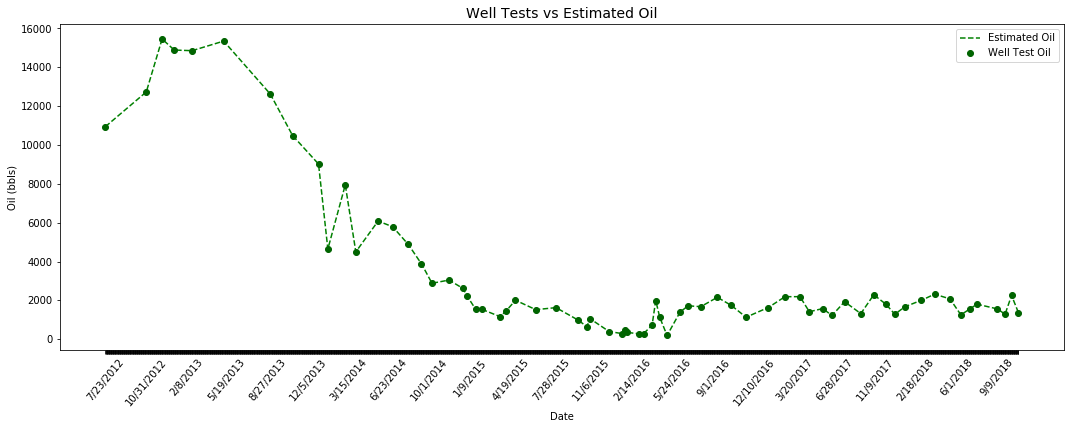

In [12]:
# Plot chart
plt.figure(figsize = (18, 6))
plt.plot(xs, y_estimated, '--', color='green')
plt.plot(xs, y_data, 'o', color='darkgreen')
plt.legend(['Estimated Oil', 'Well Test Oil'], loc='best')
plt.title('Well Tests vs Estimated Oil', fontsize = 14)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Oil (bbls)', fontsize = 10)
plt.xticks(xs, xticks, fontsize = 10, rotation = 50)
plt.show()

In [13]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = np.array([[v] for v in y_estimated])
dataset = scaler.fit_transform(dataset)

In [14]:
# split into train and test sets
train_size = len(dataset) - 60
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

2194 60


In [15]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

In [16]:
# Reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [17]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [18]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [19]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [22]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 38.94 RMSE
Test Score: 43.66 RMSE


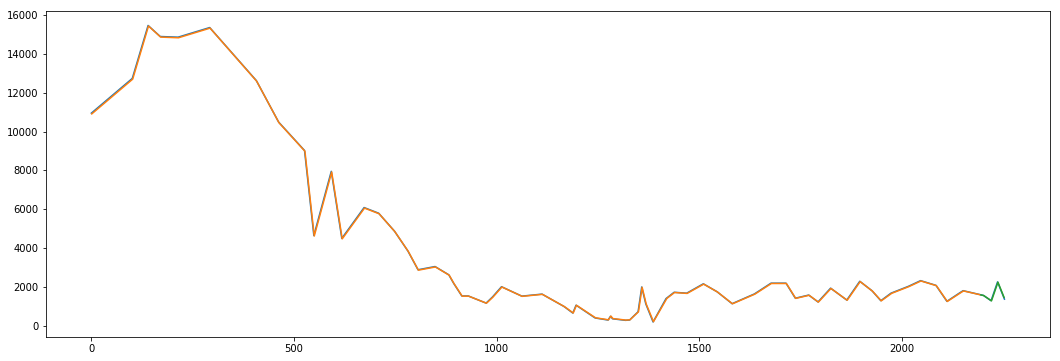

In [29]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot baseline and predictions
plt.figure(figsize = (18, 6))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<hr>
<p><a href="https://ansegura7.github.io/DataRegressors/">« Home</a></p>